In [1]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from math import prod
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import *

In [2]:
np.random.seed(42)
gum.initRandom(seed=42)

In [3]:
# Load BN and data
which = "chain_5"

gt = gum.loadBN(f"./gt_bns/{which}.bif")
data = pd.read_csv(f"gt_bns/{which}_data.csv")

data.head()

,X1,X2,X3,X4,X5
0,0,0,0,0,0
1,0,0,0,1,1
2,0,1,0,1,0
3,0,0,1,0,0
4,1,1,0,0,0


In [4]:
# Learn bn
bn_learner=gum.BNLearner(data)
bn_learner.useSmoothingPrior(1e-5)
bn = bn_learner.learnParameters(gt.dag())

# Get noisy BN (smaller 'eps' = more privacy)
eps = 1
scale = (2 * bn.size()) / (len(data) * eps)
bn_noisy = get_noisy_bn(bn, scale)

# Learn CN by local IDM
bn_counts = gum.BayesNet(bn)
add_counts(bn_counts, data)
ess = 1
cn = gum.CredalNet(bn_counts)
cn.idmLearning(ess)

In [5]:
# Plot
idx = len(gt.nodes()) - 1
gnb.flow.row(gt.cpt(idx), bn.cpt(idx), bn_noisy.cpt(idx), captions=["GT CPT", "BN CPT", "Noisy BN CPT"])

In [6]:
# Set target and evid
target = "X1"
evid = {"X3":0}

# GT MPE
gt_ie = gum.LazyPropagation(gt)
gt_ie.makeInference()

print("GT MPE: ", mpe(gt_ie, target, evid))

# BN MPE
bn_ie = gum.LazyPropagation(bn)
bn_ie.makeInference()

print("BN MPE: ", mpe(bn_ie, target, evid))

# CN MPE
cn.computeBinaryCPTMinMax()
ie_lbp = gum.CNLoopyPropagation(cn)
ie_lbp.setEvidence(evid)
ie_lbp.makeInference()

print(f"CN MPE: [{ie_lbp.marginalMin(target).argmax()}, {ie_lbp.marginalMax(target).argmax()}]")

GT MPE:  0
BN MPE:  0
CN MPE: [([{'X1': 0}], 0.595886336377403), ([{'X1': 0}], 0.5979650549623727)]


In [7]:
n_exps = 100
mpe_list = []

for i in range(n_exps):

    # Get noisy BN
    bn_noisy = get_noisy_bn(bn, scale)

    # Get object for inference
    bn_noisy_ie = gum.LazyPropagation(bn_noisy)

    # Get MPE for (target, evid)
    mpe_list.append(mpe(bn_noisy_ie, target, evid))
    

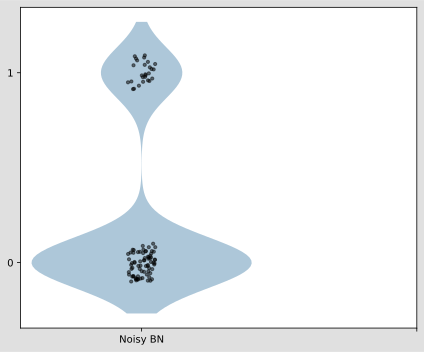

In [8]:
# Plot
plt.figure(figsize=(6, 5))
df = mpe_list

# Violinplot
sns.violinplot(
    data=df,
    inner=None,
    bw_method=0.3,
    linewidth=0,
    alpha=0.4
)

# Points
x_jittered = np.random.uniform(-0.05, 0.05, size=len(df))
y_jittered = df + np.random.uniform(-0.1, 0.1, size=len(df))
plt.scatter(x_jittered, y_jittered, color='black', alpha=0.5, s=10)

# Labels
plt.xticks([0, 1], ["Noisy BN", ""])
plt.yticks([0, 1], ["0", "1"])
plt.xlabel("")
plt.title("")

plt.tight_layout()
plt.show()
